In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')

In [15]:
data = pd.read_csv('processed_data.csv')

In [16]:
# Normalizasyon işlemleri yapıldı:
# Tempo, loudness, duration_ms değer aralıkları geniş olduğu için min-max scaling uygulandı ve diğer feature'lar ile benzer ölçeğe getirildi.
from sklearn.preprocessing import MinMaxScaler, RobustScaler

minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

# Normalize etmek istediğin kolonlar:
cols_to_scale = ['tempo', 'loudness', 'duration_ms', 'playlist_count']

# Fit ve transform işlemi
data[cols_to_scale] = minmax_scaler.fit_transform(data[cols_to_scale])


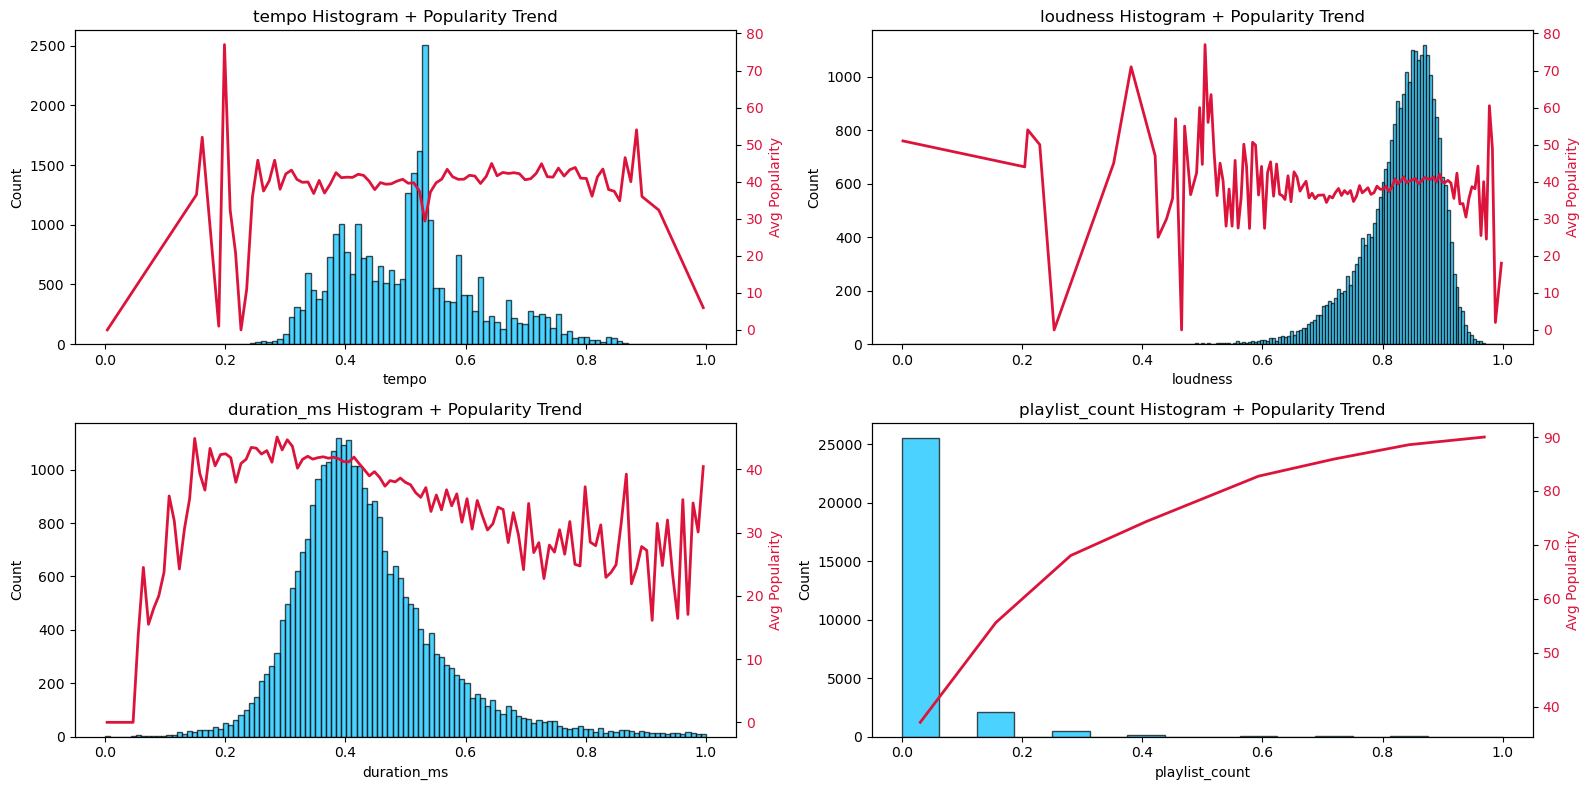

In [17]:
# Yeni dağılım grafikleri gösterildi.

n_cols = 2
n_rows = math.ceil(len(cols_to_scale) / n_cols)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 4))
ax = ax.flatten()

for i, col in enumerate(cols_to_scale):
    # Histogram (önce otomatik bin aralıklarını al)
    counts, bins, patches = ax[i].hist(data[col], bins='auto', color='deepskyblue', edgecolor='black', alpha=0.7)
    
    # Popularity ortalamaları (bin aralıklarına göre)
    bin_labels = pd.cut(data[col], bins=bins, include_lowest=True)
    grouped = data.groupby(bin_labels)['popularity'].mean().dropna()
    centers = [interval.mid for interval in grouped.index]
    bin_means = grouped.values

    # Popularity çizgisi
    ax2 = ax[i].twinx()
    ax2.plot(centers, bin_means, color='crimson', linewidth=2)
    ax2.set_ylabel('Avg Popularity', color='crimson')
    ax2.tick_params(axis='y', labelcolor='crimson')

    ax[i].set_title(f'{col} Histogram + Popularity Trend')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Count')

# Boş kalan hücreleri gizle
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [18]:
# Yapılan görselleştirmelerde üretkenlik-popülarite ilişkisi görülmüştür. Sanatçının aktifliğinin popülariteyi etkileyebileceği düşünülmüştür.
# Sanatçıların çıkardıkları toplam şarkı sayısının modele faydası olabileceği öngörülmüştür.
# Sanatçının toplam şarkı sayısı özelliği eklenmiştir.

# Her sanatçının toplam şarkı sayısını hesapla
artist_song_counts = data['artist'].value_counts().to_dict()

# Yeni bir sütun ekleme: her satıra o sanatçının toplam şarkı sayısını ata
data['artist_song_count'] = data['artist'].map(artist_song_counts)

In [19]:
# Artist Ortalama Popülaritesi-Şarkı Popülaritesi ilişkisi görülmüştür. Sanatçıların ortalama popülerliğinin, şarkılarının performansını ve popülerliğini etkileyeceği düşünülmüştür.
# Sanatçıların ortalama popülerliklerinin modelin tahmin yeteğine katkı sağlayabileceği öngörülmüştür.
# Sanatçının ortalama popülarite özelliği eklenmiştir.

# Her sanatçının ortalama popülerliğini hesapla
artist_avg_popularity = data.groupby('artist')['popularity'].mean().to_dict()

# Yeni bir sütun ekle: her satıra o sanatçının ortalama popülerliğini ata
data['artist_avg_popularity'] = data['artist'].map(artist_avg_popularity)

In [20]:
# Artist Başarı Yüzdesi-Şarkı Popülaritesi ilişkisi görülmüştür. Sanatçının şarkıları içindeki başarı yüzdesi, sanatçının hit üretme kapasitesini gösterir ve şarkılarının popülaritesini etkiler.
# Sadece üretkenliği değil, aynı zamanda kaliteyi de yansıttığı için modele faydası olabileceği öngörülmüştür.
# Şarkıcının yüksek popüler şarkı oranı özelliği eklenmiştir.

# 3. Her sanatçının yüksek popüler şarkı oranını hesapla
percentile_90 = data['popularity'].quantile(0.90)
artist_high_popularity_count = data[data['popularity'] > percentile_90].groupby('artist').size().to_dict()

# Geçici olarak count hesapla ama sütun oluşturma
artist_high_pop_count_temp = data['artist'].map(artist_high_popularity_count).fillna(0)

# Sadece ratio'yu sütun olarak ekle
data['artist_high_pop_ratio'] = artist_high_pop_count_temp / data['artist_song_count']

In [21]:
# # Normalize etmek istediğin kolonlar:
# cols_to_scale = ['artist_song_count', 'artist_avg_popularity']

# # Fit ve transform işlemi
# data[cols_to_scale] = minmax_scaler.fit_transform(data[cols_to_scale])

In [22]:
data.columns

Index(['track_id', 'name', 'artist', 'album_id', 'album_name', 'popularity',
       'album_release_date', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'playlist_count', 'genre_edm',
       'genre_latin', 'genre_pop', 'genre_r&b', 'genre_rap', 'genre_rock',
       'subgenre_album rock', 'subgenre_big room', 'subgenre_classic rock',
       'subgenre_dance pop', 'subgenre_electro house', 'subgenre_electropop',
       'subgenre_gangster rap', 'subgenre_hard rock', 'subgenre_hip hop',
       'subgenre_hip pop', 'subgenre_indie poptimism',
       'subgenre_latin hip hop', 'subgenre_latin pop', 'subgenre_neo soul',
       'subgenre_new jack swing', 'subgenre_permanent wave',
       'subgenre_pop edm', 'subgenre_post-teen pop',
       'subgenre_progressive electro house', 'subgenre_reggaeton',
       'subgenre_southern hip hop', 'subgenre_trap', 'subgenre_tropical',
       's

In [23]:
# Kategorik değerli sütunlar için one-hot encoding uygulandı.
data = pd.get_dummies(data, columns=['key'], prefix='key', dtype=int)

# Yeni kolonları gösterme:
print(data.columns)

Index(['track_id', 'name', 'artist', 'album_id', 'album_name', 'popularity',
       'album_release_date', 'danceability', 'energy', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'playlist_count', 'genre_edm',
       'genre_latin', 'genre_pop', 'genre_r&b', 'genre_rap', 'genre_rock',
       'subgenre_album rock', 'subgenre_big room', 'subgenre_classic rock',
       'subgenre_dance pop', 'subgenre_electro house', 'subgenre_electropop',
       'subgenre_gangster rap', 'subgenre_hard rock', 'subgenre_hip hop',
       'subgenre_hip pop', 'subgenre_indie poptimism',
       'subgenre_latin hip hop', 'subgenre_latin pop', 'subgenre_neo soul',
       'subgenre_new jack swing', 'subgenre_permanent wave',
       'subgenre_pop edm', 'subgenre_post-teen pop',
       'subgenre_progressive electro house', 'subgenre_reggaeton',
       'subgenre_southern hip hop', 'subgenre_trap', 'subgenre_tropical',
       'subgenre

In [24]:
# Modele dahil edilmeyecek sütunlar kaldırıldı.
columns_to_drop = [ 'album_id', 
                   'album_name', 
                   'name', 
                   'album_release_date', 
                   'track_id',
                   'artist'
]

data = data.drop(columns=columns_to_drop)
print(data.columns)
print(len(data.columns))

Index(['popularity', 'danceability', 'energy', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'playlist_count', 'genre_edm',
       'genre_latin', 'genre_pop', 'genre_r&b', 'genre_rap', 'genre_rock',
       'subgenre_album rock', 'subgenre_big room', 'subgenre_classic rock',
       'subgenre_dance pop', 'subgenre_electro house', 'subgenre_electropop',
       'subgenre_gangster rap', 'subgenre_hard rock', 'subgenre_hip hop',
       'subgenre_hip pop', 'subgenre_indie poptimism',
       'subgenre_latin hip hop', 'subgenre_latin pop', 'subgenre_neo soul',
       'subgenre_new jack swing', 'subgenre_permanent wave',
       'subgenre_pop edm', 'subgenre_post-teen pop',
       'subgenre_progressive electro house', 'subgenre_reggaeton',
       'subgenre_southern hip hop', 'subgenre_trap', 'subgenre_tropical',
       'subgenre_urban contemporary', 'artist_avg_popularity',
       'artist_song_count', 'artist_hi

In [25]:
# Tüm numerik sütunların değer aralıklarını kontrol et
print("=" * 80)
print("TÜM SÜTUNLARIN DEĞER ARALIKLARI")
print("=" * 80)

# Numerik sütunları al
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Her sütun için min, max, range bilgisini göster
range_info = pd.DataFrame({
    'Column': numeric_cols,
    'Min': [data[col].min() for col in numeric_cols],
    'Max': [data[col].max() for col in numeric_cols],
    'Range': [data[col].max() - data[col].min() for col in numeric_cols],
    'Mean': [data[col].mean() for col in numeric_cols],
    'Std': [data[col].std() for col in numeric_cols]
})

# Range'e göre sırala (büyükten küçüğe)
range_info = range_info.sort_values('Range', ascending=False)

print("\n" + "=" * 80)
print("RANGE'E GÖRE SIRALANMIŞ SÜTUNLAR:")
print("=" * 80)
print(range_info.to_string(index=False))

# Normalize edilmesi gereken sütunları belirle (0-1 aralığında olmayanlar)
needs_normalization = range_info[(range_info['Min'] < 0) | (range_info['Max'] > 1)]

print("\n" + "=" * 80)
print("NORMALİZE EDİLMESİ GEREKEN SÜTUNLAR (0-1 dışında):")
print("=" * 80)
if len(needs_normalization) > 0:
    print(needs_normalization[['Column', 'Min', 'Max', 'Range']].to_string(index=False))
else:
    print("Tüm sütunlar 0-1 aralığında! ✓")

# One-hot encoded sütunları kontrol et
one_hot_cols = [col for col in data.columns if col.startswith(('key_', 'genre_', 'subgenre_'))]
print(f"\n" + "=" * 80)
print(f"ONE-HOT ENCODED SÜTUNLAR: {len(one_hot_cols)} adet")
print("=" * 80)
print("Örnek key sütunları:", [col for col in one_hot_cols if col.startswith('key_')][:5])
print("Örnek genre sütunları:", [col for col in one_hot_cols if col.startswith('genre_')][:5])
print("Örnek subgenre sütunları:", [col for col in one_hot_cols if col.startswith('subgenre_')][:5])

# 0-1 aralığında olan feature'ları göster
normalized_cols = range_info[(range_info['Min'] >= 0) & (range_info['Max'] <= 1)]
print("\n" + "=" * 80)
print(f"ZATEN 0-1 ARALIGINDA OLAN SÜTUNLAR: {len(normalized_cols)} adet")
print("=" * 80)
print(normalized_cols[['Column', 'Min', 'Max']].to_string(index=False))

TÜM SÜTUNLARIN DEĞER ARALIKLARI

RANGE'E GÖRE SIRALANMIŞ SÜTUNLAR:
                            Column      Min     Max      Range      Mean       Std
                 artist_song_count 1.000000 130.000 129.000000 11.385527 16.923331
                        popularity 0.000000 100.000 100.000000 39.329771 23.702376
             artist_avg_popularity 0.000000  97.000  97.000000 39.329771 17.504857
                         genre_rap 0.000000   1.000   1.000000  0.193469  0.395024
                              mode 0.000000   1.000   1.000000  0.565489  0.495701
                         genre_r&b 0.000000   1.000   1.000000  0.181196  0.385187
                       genre_latin 0.000000   1.000   1.000000  0.163669  0.369982
                         genre_edm 0.000000   1.000   1.000000  0.195267  0.396413
                         genre_pop 0.000000   1.000   1.000000  0.180985  0.385012
                          loudness 0.000000   1.000   1.000000  0.830424  0.063622
                subg